In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
DataPath = "F:/articles/head and neck segmentation/archive1/lgg-mri-segmentation/kaggle_3m"

# Collect image and mask paths
dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask' in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [4]:
print(masks[:10], images[:10])
print(len(dirs), len(images), len(masks))

['TCGA_CS_4941_19960909_10_mask.tif', 'TCGA_CS_4941_19960909_11_mask.tif', 'TCGA_CS_4941_19960909_12_mask.tif', 'TCGA_CS_4941_19960909_13_mask.tif', 'TCGA_CS_4941_19960909_14_mask.tif', 'TCGA_CS_4941_19960909_15_mask.tif', 'TCGA_CS_4941_19960909_16_mask.tif', 'TCGA_CS_4941_19960909_17_mask.tif', 'TCGA_CS_4941_19960909_18_mask.tif', 'TCGA_CS_4941_19960909_19_mask.tif'] ['TCGA_CS_4941_19960909_10.tif', 'TCGA_CS_4941_19960909_11.tif', 'TCGA_CS_4941_19960909_12.tif', 'TCGA_CS_4941_19960909_13.tif', 'TCGA_CS_4941_19960909_14.tif', 'TCGA_CS_4941_19960909_15.tif', 'TCGA_CS_4941_19960909_16.tif', 'TCGA_CS_4941_19960909_17.tif', 'TCGA_CS_4941_19960909_18.tif', 'TCGA_CS_4941_19960909_19.tif']
3929 3929 3929


In [5]:
# Create dataframe
imagePath_df = pd.DataFrame({'directory': dirs, 'images': images, 'masks': masks})
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks'] 


In [6]:
# Split data
train, test = train_test_split(imagePath_df, test_size=0.25, random_state=21)


In [8]:
# Define parameters
EPOCHS = 20
BATCH_SIZE = 8
ImgHeight = 256
ImgWidth = 256
Channels = 3

In [9]:
# Data augmentation
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')


In [10]:
# Image and mask generators
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


In [11]:
timage_generator = imagegen.flow_from_dataframe(dataframe=train,
                                                x_col="image-path",
                                                batch_size=BATCH_SIZE,
                                                seed=42,
                                                class_mode=None,
                                                target_size=(ImgHeight, ImgWidth),
                                                color_mode='rgb')

tmask_generator = maskgen.flow_from_dataframe(dataframe=train,
                                              x_col="mask-path",
                                              batch_size=BATCH_SIZE,
                                              seed=42,
                                              class_mode=None,
                                              target_size=(ImgHeight, ImgWidth),
                                              color_mode='grayscale') 


Found 2946 validated image filenames.
Found 2946 validated image filenames.


In [12]:
vimage_generator = imagegen.flow_from_dataframe(dataframe=test,
                                                x_col="image-path",
                                                batch_size=BATCH_SIZE,
                                                seed=42,
                                                class_mode=None,
                                                target_size=(ImgHeight, ImgWidth),
                                                color_mode='rgb')

vmask_generator = maskgen.flow_from_dataframe(dataframe=test,
                                              x_col="mask-path",
                                              batch_size=BATCH_SIZE,
                                              seed=42,
                                              class_mode=None,
                                              target_size=(ImgHeight, ImgWidth),
                                              color_mode='grayscale')


Found 983 validated image filenames.
Found 983 validated image filenames.


In [13]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask


In [14]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)


In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [16]:
def get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [17]:
input_img = Input((ImgHeight, ImgWidth, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ img[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [19]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('D:/model-brain-mri.keras', verbose=1, save_best_only=True)
]


In [20]:
STEP_SIZE_TRAIN = 100
STEP_SIZE_VALID = 100

In [19]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9777 - loss: 0.2847
Epoch 1: val_loss improved from inf to 0.14483, saving model to D:/model-brain-mri.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9778 - loss: 0.2840 - val_accuracy: 0.9894 - val_loss: 0.1448 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.9848 - loss: 0.1059
Epoch 2: val_loss improved from 0.14483 to 0.07458, saving model to D:/model-brain-mri.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9848 - loss: 0.1058 - val_accuracy: 0.9896 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.9906 - loss: 0.0578
Epoch 3: val_loss improved from 0.07458 to 0.05606, saving model to D:/model-brain-mri.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9906 - loss: 0.0577 - val_accuracy: 0.9911 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


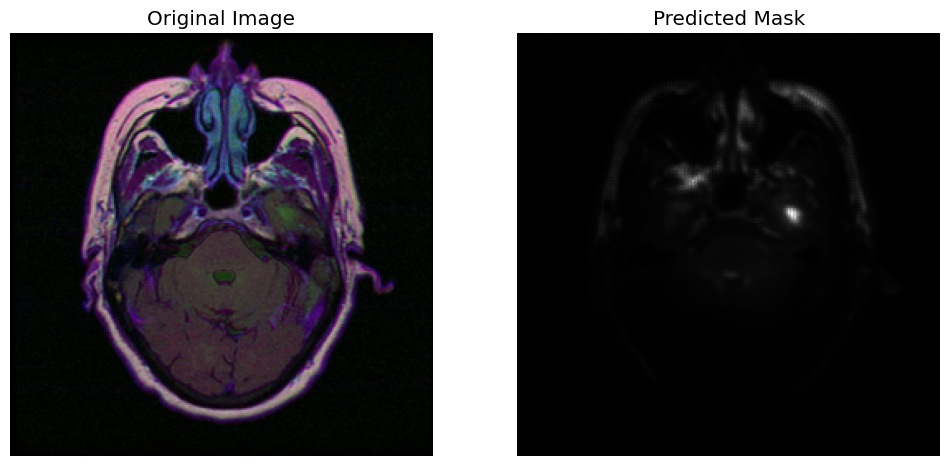

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

ImgHeight = 256
ImgWidth = 256

model_path = "F:/articles/head and neck segmentation/train model/model-brain-mri.keras"  
model = load_model(model_path)

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (ImgWidth, ImgHeight))
    image = image / 255.0 
    image = np.expand_dims(image, axis=0)  
    return image

def predict_image(image_path, model):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    return prediction[0, :, :, 0]  

def save_mask(mask, output_path):
    mask = (mask * 255).astype(np.uint8)
    if not cv2.imwrite(output_path, mask):
        raise ValueError(f"Could not save the image to {output_path}. Check the file path and extension.")

test_image_path = "F:/articles/head and neck segmentation/archive1/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_16.tif"
output_mask_path = "D:/output.tif"  # مسیر ذخیره ماسک را تغییر دهید

# پیش‌بینی ماسک
predicted_mask = predict_image(test_image_path, model)

# ذخیره ماسک
save_mask(predicted_mask, output_mask_path)

# نمایش نتایج
plt.figure(figsize=(12, 6))

# نمایش تصویر اصلی
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')

# نمایش ماسک پیش‌بینی شده
plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.show()



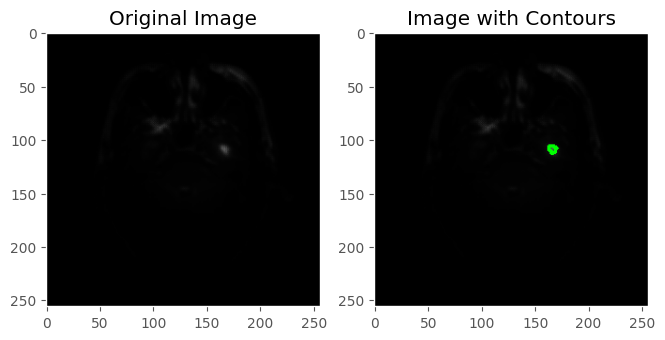

In [24]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image_path = "D:/output.tif"
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 50, 150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    cropped_image = image[y:y+h, x:x+w]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 2)
    plt.title('Image with Contours')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    
    plt.show()
    
    cv2.imwrite('D:/image_with_contours.tif', image_with_contours)
    cv2.imwrite('image_with_box.tif', image_with_box)
else:
    print("No contours found")


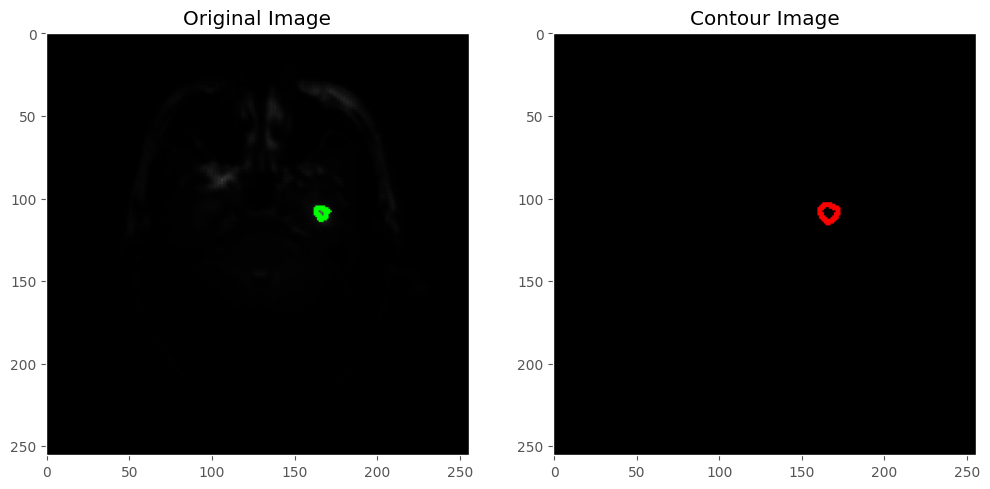

True

In [27]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image_path = 'D:/image_with_contours.tif' 
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 50, 150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = np.zeros_like(image)

cv2.drawContours(contour_image, contours, -1, (0, 0, 255), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.grid(False)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Contour Image')
plt.grid(False)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))

plt.show()

cv2.imwrite('contour_image.tif', contour_image)


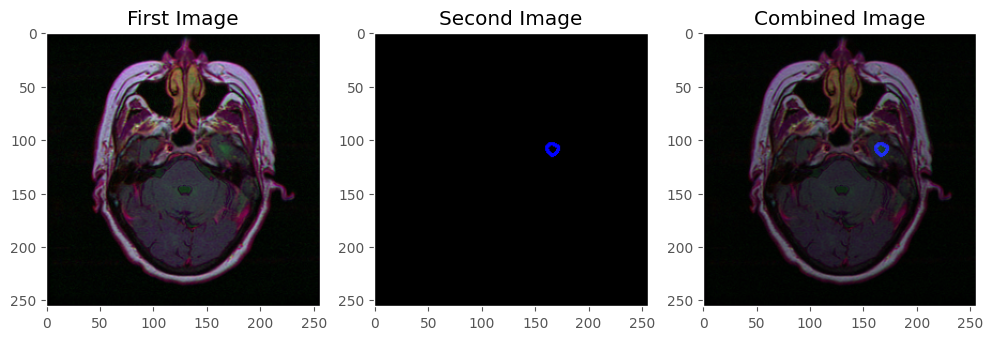

In [28]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image1_path = "F:/articles/head and neck segmentation/archive1/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_16.tif"   
image2_path = 'contour_image.tif'  

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

if image1.shape != image2.shape:
    print("The dimensions of the two images do not match.")
else:
    alpha = 0.7  
    beta = 0.8  
    gamma = 0    

    combined_image = cv2.addWeighted(image1, alpha, image2, beta, gamma)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('First Image')
    plt.grid(False)
    plt.imshow(image1)

    plt.subplot(1, 3, 2)
    plt.title('Second Image')
    plt.grid(False)
    plt.imshow(image2)

    plt.subplot(1, 3, 3)
    plt.title('Combined Image')
    plt.imshow(combined_image)
    plt.grid(False)
    plt.show()

    cv2.imwrite('combined_image2.png', combined_image)
